# 商务智能：Final Project 
* 成员：
    * 吴越 2024211326    
    * 张铭轩 2024211332     
    * 卜方婧 2024211340
* 日期：2024.10.22

# Goal
* 基于Amazon在线评论数据集，建立推荐系统。
   
# 步骤
* 数据预处理：
    * 处理文本文件：将brands.txt & categories.txt转换为csv文件，categories文件只保留一级分类；
    * 
    

# 加载包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from sentence_transformers import SentenceTransformer, models

# 数据预处理

## 处理文本文件
* brands.txt & categories.txt

In [16]:
# brand.txt预处理，保存为csv文件
brands = [] # 此列表保存brands信息，其中每个元素对应一行数据，读取为含两个元素的列表
with open('./data/brands.txt', 'r',encoding = 'ISO-8859-1') as f:
    for line in f.readlines():
        line = line.strip('\n').split(" ", 1) # 每一行第一个元素是product/productId，第二个元素是Product/Brand
        brands.append(line)
        
brands_df = pd.DataFrame(brands, columns=['productId', 'brand']) 
brands_df.to_csv('./data/brands_df.csv')

In [17]:
brands_df.head()

,productId,brand
0,B0000A0QE6,Jos. A. Bank
1,B0000A0QE2,Jos. A. Bank
2,B0000C2LF3,Canyon Ridge
3,B0000C2LF7,Canyon Ridge
4,B0006V0BA2,necessary objects


In [9]:
# categories.txt预处理，保存为csv文件
categories_origin = [] 
pair = 0
with open('./data/categories.txt', 'r',encoding = 'ISO-8859-1') as f:
    for line in f.readlines():  
        line = line.strip('\n')
        # 每次遇到新product时，产生一个pair列表，
        # 其中第一个元素是productId，后面的元素不固定长，分别是其所属的类别
        
        if line[0]==" ":   # 如果遇到类别所属行，则将改行空格去除，在pair中添加该类别
            line = line.strip()
            pair.append(line)
        else: # 如果遇到新product所属行，则在categories_origin中添加现有（上一个）product信息，并重新设置pair
            categories_origin.append(pair)
            pair = []
            pair.append(line)
    
    categories_origin.append(pair) # 最后一个product的数据
        
categories_origin.pop(0)       

# 由于每个product对应很多类别，所以每个product每个类别变为一个新行，其层数（能填的列数）不固定
first_category_set = set()
categories = []
no_categories_index = set()
l = len(categories_origin)
for i in range(l):
    i_list = categories_origin[i] # 和之前的pair对应，第一个元素是productId，后面的元素不固定长，分别是其所属的类别
    productId_i = i_list[0] # productId
    category_num_i = len(i_list)-1 # 该product所属类别数
    for j in range(category_num_i): # 对该product的每个类别
        categories_i_j = i_list[j+1].split(',')
        categories_i_j = [x.strip() for x in categories_i_j]
        if categories_i_j[0]!='':
            first_category_set.add(categories_i_j[0])
            categories.append([productId_i.strip()]+categories_i_j) # 产生一个新行
        else:
            #print(i_list,'该product没有所属类别信息')
            no_categories_index.add(i)

categories_df = pd.DataFrame(categories)

In [10]:
print(f'共有{len(categories_origin)}个product')
print(f'其中有{len(no_categories_index)}个product没有类别信息，占比{len(no_categories_index)/len(categories_origin)}，删去')
categories_origin_update = [categories_origin[i] for i in range(len(categories_origin)) if i not in no_categories_index]
print(f'剩余{len(categories_origin_update)}个product')

共有2441053个product
其中有2619个product没有类别信息，占比0.001072897638846842，删去
剩余2438434个product


In [20]:
categories_df = categories_df.iloc[:,:2]
categories_df.columns = ['productId', 'categories']
categories_df.to_csv('./data/categories_df.csv')

In [21]:
categories_df.head()

,productId,categories
0,B0027DQHA0,Movies & TV
1,B0027DQHA0,Music
2,0756400120,Books
3,0756400120,Books
4,0756400120,Books


## One-Hot
* categories_1：product i 如果属于category c,则对应category_c=1
* brand: 由于brand空值较多（达到99%以上），只考虑评论数量最多的10个品牌；product i 如果属于brand b，则对应brand_b=1

### Categories

In [120]:
# 处理categories
categories_df = pd.read_csv('./data/categories_df.csv',index_col=0)
categories_df.head(2)

,productId,categories
0,B0027DQHA0,Movies & TV
1,B0027DQHA0,Music


In [126]:
# one-hot编码categories
cat_encoder = OneHotEncoder(sparse=False)
cat_encoded_array = cat_encoder.fit_transform(categories_df[['categories']])
cat_encoded_df = pd.DataFrame(cat_encoded_array, columns=cat_encoder.get_feature_names_out(['categories']))
cat_encoded_df = pd.concat([categories_df, cat_encoded_df], axis=1)

d:\ana\envs\python\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [137]:
cat_encoded_df.drop(columns=['categories'], inplace=True)
cat_encoded_df=cat_encoded_df.groupby('productId').sum()
#cat_encoded_df大于1的元素变成1(类别数据存在重复)
cat_encoded_df[cat_encoded_df>1]=1
cat_encoded_df.reset_index(inplace=True)

In [170]:
cat_encoded_df.head(2)

,productId,categories_All Electronics,categories_Alternative Rock,categories_Amazon Instant Video,categories_Amazon MP3 Store,categories_Appliances,categories_Arts,categories_Automotive,categories_Baby,categories_Baby Products,...,categories_Rap & Hip-Hop,categories_Rock,categories_Shoes,categories_Software,categories_Sports & Outdoors,categories_Tools & Home Improvement,categories_Toys & Games,categories_Video Games,categories_Watches,categories_World Music
0,0000000868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000020214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Brands
* 由于brands空值占比较多，大于99%，故只考虑review数量前10的品牌，以刻画某些用户的品牌粘性
* 生成10维向量，1表示product属于该品牌

In [143]:
# 处理brands
# products_reviews数据
products_reviews = pd.read_csv('./data/products_reviews.csv',index_col=0)
products_reviews.columns = ['productId', 'title', 'userId', 'profileName', 'helpfulness', 'score', 'time', 'summary', 'index']
products_reviews.drop_duplicates(['productId', 'title', 'userId','score','time','summary', 'helpfulness'],inplace=True) #数据可能有重复，且对应index不同

brands_df = pd.read_csv('./data/brands_df.csv',index_col=0)
see_brands_count = pd.merge(products_reviews, brands_df, on='productId', how='left')

In [145]:
# 空值比例
def showPercentageNan(colName, dtFrame):
    perc = (dtFrame[colName].isnull().sum() / dtFrame.shape[0])
    print(f"Percent of missing ''{colName}'' records is {round(perc * 100,7)} %")

colNan = see_brands_count.columns.tolist()

for col in colNan:
    showPercentageNan(col, see_brands_count)

Percent of missing ''productId'' records is 0.0 %
Percent of missing ''title'' records is 0.0059804 %
Percent of missing ''userId'' records is 0.0 %
Percent of missing ''profileName'' records is 0.0074755 %
Percent of missing ''helpfulness'' records is 0.0 %
Percent of missing ''score'' records is 0.0 %
Percent of missing ''time'' records is 0.0 %
Percent of missing ''summary'' records is 0.0019935 %
Percent of missing ''index'' records is 0.0 %
Percent of missing ''brand'' records is 99.27438 %


In [152]:
# top 10
select_brand=see_brands_count.groupby('brand')["index"].count().sort_values(ascending=False).head(10).index

In [154]:
brands_df["brand"]=brands_df["brand"].apply(lambda x: x if x in select_brand else np.nan)

In [157]:
# one-hot编码categories
b_encoder = OneHotEncoder(sparse=False)
b_encoded_array = b_encoder.fit_transform(brands_df[['brand']])
b_encoded_df = pd.DataFrame(b_encoded_array, columns=b_encoder.get_feature_names_out(['brand']))
b_encoded_df = pd.concat([brands_df, b_encoded_df], axis=1)

d:\ana\envs\python\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [161]:
b_encoded_df.drop(columns=['brand','brand_nan'], inplace=True)

In [169]:
b_encoded_df.head(2)

,productId,brand_Carolyn Forsman,brand_Dakota,brand_Diesel,brand_Fossil,brand_Freestyle,brand_Great Eastern Entertainment,brand_Pro-Tec,"brand_Serenity Crystals, Inc.",brand_Skagen,brand_Timbuk2
0,B0000A0QE6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B0000A0QE2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 合并数据
* 以products_reviews为主文件，合并
    * brands（b_encoded_df）,
    * categories（cat_encoded_df）,
    * reviews_text

In [173]:
products_reviews = pd.read_csv('./data/products_reviews.csv',index_col=0)
products_reviews.columns = ['productId', 'title', 'userId', 'profileName', 'helpfulness', 'score', 'time', 'summary', 'index']
products_reviews.drop_duplicates(['productId', 'title', 'userId','score','time','summary', 'helpfulness'],inplace=True) #数据可能有重复，且对应index不同
products_reviews.shape

(200656, 9)

In [172]:
# 合并products_reviews和categories
data = pd.merge(products_reviews, cat_encoded_df, on='productId', how='left')
data.shape

(200656, 71)

In [174]:
# 合并data和brands
data = pd.merge(data, b_encoded_df, on='productId', how='left')
data.shape

(200656, 81)

In [175]:
# 合并data和reviews_text
reviews_text = pd.read_csv('./data/reviews_text.csv',index_col=0)
reviews_text.columns = ['index', 'review']
data = pd.merge(data, reviews_text, on='index', how='left')
data.shape

(200656, 82)

In [179]:
data.fillna(0, inplace=True)    # 将空值填充为0

In [181]:
data.head(2)

,productId,title,userId,profileName,helpfulness,score,time,summary,index,categories_All Electronics,...,brand_Dakota,brand_Diesel,brand_Fossil,brand_Freestyle,brand_Great Eastern Entertainment,brand_Pro-Tec,"brand_Serenity Crystals, Inc.",brand_Skagen,brand_Timbuk2,review
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,2009/01/31,Don't buy!,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"First of all, the company took my money and se..."
1,B000F1UQJY,Motorola HT820 Stereo Bluetooth Headset with m...,AYAXWDXO97UKG,J. Tomlinson,0/0,5.0,2012/08/17,Gold Standard,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I've gone through many different bluetooth hea...


## Encode
* 将 userId & productId 编码，使得机器可以学习到同一用户/商品的特点

In [185]:
# encode productId
labelencoder_product = LabelEncoder()
data["productId_encode"] = labelencoder_product.fit_transform(data["productId"])

In [187]:
# encode userId
labelencoder_user = LabelEncoder()
data["userId_encode"] = labelencoder_user.fit_transform(data["userId"])

In [188]:
data.to_csv('./data/data.csv')

## 生成特征：用户的购买记录
* 对于user u与时间t，累加时间t之前的brand以及categories向量

In [189]:
data=pd.read_csv('./data/data.csv',index_col=0)

In [202]:
# 筛选data.columns中以 categories_ 开头的列
categories_columns = [col for col in data.columns if 'categories_' in col]
# 筛选data.columns中以 brand_ 开头的列
brand_columns = [col for col in data.columns if 'brand_' in col]

In [197]:
data_hist = data.sort_values(by=['time']) # 按时间排序

In [208]:
data_hist.head(2)

,productId,title,userId,profileName,helpfulness,score,time,summary,index,categories_All Electronics,...,brand_Fossil,brand_Freestyle,brand_Great Eastern Entertainment,brand_Pro-Tec,"brand_Serenity Crystals, Inc.",brand_Skagen,brand_Timbuk2,review,productId_encode,userId_encode
136971,B0002E2XD6,"Fender 351 Premium Celluloid Guitar Picks, 12 ...",A2XJM0QWB9MTW2,Terry,0/0,5.0,2008/01/11,Guitar picks,137013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The picks are awesome. My son loved them. Pack...,5482,84608
153842,B000CDL9IC,Invicta Men's 9310 Pro Diver Collection Swiss ...,A2PGQ8UQMIWF21,"David Adams ""David""",2/3,5.0,2008/01/11,"""A watch for the ages""",153884,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,I ordered this Invicta Watch for my brother as...,19642,74928


In [210]:
data_1 = data_hist.groupby('userId')[categories_columns+brand_columns].cumsum()
#将data_1的columns名字前都加上his_
data_1.columns = ['his_'+col for col in data_1.columns]

In [217]:
data_hist = pd.concat([data_hist, data_1], axis=1)

In [218]:
data_hist.to_parquet('./data/data_hist.parquet')

## 划分训练集&测试集

In [2]:
data_hist=pd.read_parquet('./data/data_hist.parquet')

In [3]:
data_hist.columns

Index(['productId', 'title', 'userId', 'profileName', 'helpfulness', 'score',
       'time', 'summary', 'index', 'categories_All Electronics',
       ...
       'his_brand_Carolyn Forsman', 'his_brand_Dakota', 'his_brand_Diesel',
       'his_brand_Fossil', 'his_brand_Freestyle',
       'his_brand_Great Eastern Entertainment', 'his_brand_Pro-Tec',
       'his_brand_Serenity Crystals, Inc.', 'his_brand_Skagen',
       'his_brand_Timbuk2'],
      dtype='object', length=156)

In [4]:
def get_train_test(data):
    '''
    split train - test data
    '''
    temp = data.sample(frac = 0.1).index
    test_temp = data.loc[temp]
    train_temp = data.loc[~data.index.isin(temp)]
    temp = test_temp[(test_temp['userId_encode'].isin(train_temp['userId_encode']))&(
        test_temp['productId_encode'].isin(train_temp['productId_encode']))].index
    test = test_temp.loc[temp]
    train = data.loc[~data.index.isin(temp)]
    return train,test

In [5]:
data_test = pd.DataFrame()
data_train = data_hist.copy()
while len(data_test)<len(data_hist)*0.1:
    data_train,test1 = get_train_test(data_train)
    data_test = pd.concat([data_test,test1])

In [6]:
print("训练集数量:",len(data_train))
print("测试集数量:",len(data_test))

训练集数量: 180275
测试集数量: 20381


## 生成特征：产品的相关特征
* 计算`train_score_mean`与，以刻画产品特征
* `train_score_mean`: 训练集上，product i 的得分均值，可以捕捉产品质量等
* `helpfulness_helpful`: 训练集上，product i 的所有helpfulness中分子的总和，衡量product i对应评论的质量
* `helpfulness_total`: 训练集上，product i 的所有helpfulness中分母的总和，衡量product i对应评论的“人气”

In [8]:
# trian_mean_score
train_mean_score=pd.DataFrame(data_train.groupby(["productId_encode"])["score"].mean())
train_mean_score.reset_index(inplace=True)
train_mean_score.columns=["productId_encode","train_mean_score"]

In [9]:
train_mean_score

,productId_encode,train_mean_score
0,0,4.333333
1,1,5.000000
2,2,3.500000
3,3,4.000000
4,4,2.333333
...,...,...
37507,37507,5.000000
37508,37508,4.572368
37509,37509,4.000000
37510,37510,5.000000


In [10]:
# helpfulness
data_train_1=data_train[["productId_encode","helpfulness"]]
data_train_1["helpfulness_helpful"]=data_train_1["helpfulness"].apply(lambda x: int(x.split("/")[0]))
data_train_1["helpfulness_total"]=data_train_1["helpfulness"].apply(lambda x: int(x.split("/")[1]))

C:\Users\Kitty Bu\AppData\Local\Temp\ipykernel_13368\2624857791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_1["helpfulness_helpful"]=data_train_1["helpfulness"].apply(lambda x: int(x.split("/")[0]))
C:\Users\Kitty Bu\AppData\Local\Temp\ipykernel_13368\2624857791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_1["helpfulness_total"]=data_train_1["helpfulness"].apply(lambda x: int(x.split("/")[1]))


In [11]:
helpfulness_helpful = pd.DataFrame(data_train_1.groupby("productId_encode")["helpfulness_helpful"].sum())
helpfulness_helpful.reset_index(inplace=True)
helpfulness_helpful.columns=["productId_encode","helpfulness_helpful"]
helpfulness_total = pd.DataFrame(data_train_1.groupby("productId_encode")["helpfulness_total"].sum())
helpfulness_total.reset_index(inplace=True)
helpfulness_total.columns=["productId_encode","helpfulness_total"]

In [12]:
# 分别与train&test合并
data_train = pd.merge(data_train,train_mean_score,on="productId_encode",how="left")
data_train = pd.merge(data_train,helpfulness_helpful,on="productId_encode",how="left")
data_train = pd.merge(data_train,helpfulness_total,on="productId_encode",how="left")

data_test = pd.merge(data_test,train_mean_score,on="productId_encode",how="left")
data_test = pd.merge(data_test,helpfulness_helpful,on="productId_encode",how="left")
data_test = pd.merge(data_test,helpfulness_total,on="productId_encode",how="left")

## 生成特征：summary&review连接
* 对于product i，将训练集中的所有summary (review) 连接在一起
* 每个product对应一个`long_summary`和一个`long_review`，作为产品特征

In [13]:
long_summary = pd.DataFrame(data_train.groupby("productId_encode")["summary"].sum())
long_summary.reset_index(inplace=True)
long_summary.columns=["productId_encode","long_summary"]

In [14]:
long_review = pd.DataFrame(data_train.groupby("productId_encode")["review"].sum())
long_review.reset_index(inplace=True)
long_review.columns=["productId_encode","long_review"]

In [15]:
long_review.to_parquet('long_review.parquet')
long_summary.to_parquet('long_summary.parquet')

In [16]:
data_train.drop(columns=["productId","userId","profileName","helpfulness","time","summary","review"], inplace=True)
data_test.drop(columns=["productId","userId","profileName","helpfulness","time","summary","review"], inplace=True)

In [17]:
data_test.head(2)

,title,score,index,categories_All Electronics,categories_Alternative Rock,categories_Amazon Instant Video,categories_Amazon MP3 Store,categories_Appliances,categories_Arts,categories_Automotive,...,his_brand_Fossil,his_brand_Freestyle,his_brand_Great Eastern Entertainment,his_brand_Pro-Tec,"his_brand_Serenity Crystals, Inc.",his_brand_Skagen,his_brand_Timbuk2,train_mean_score,helpfulness_helpful,helpfulness_total
0,Casio Men's Techmowear Remote Control Digital ...,4.0,153012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.125000,12,19
1,Auralex GRAMMA: Amp and Monitor Isolation Rise...,4.0,100729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.428571,80,84


In [18]:
data_train.to_parquet("data_train.parquet")
data_test.to_parquet("data_test.parquet")

## BERT-Based Embedding
* google-bert/bert-base-uncased [介绍文档](https://huggingface.co/google-bert/bert-base-uncased)
* sentence-transformer [介绍文档](https://huggingface.co/sentence-transformers)
* 使用BERT对`title`, `long_summary`进行embedding.

### Embedding title

In [7]:
# 使用sentence_transformers比transformer计算更快
embedding_title = models.Transformer('D:/BERT/bert-base-uncased/', max_seq_length = 256) 
pooling_model = models.Pooling(embedding_title.get_word_embedding_dimension()) # 平均池化层
model = SentenceTransformer(modules=[embedding_title, pooling_model]) # 总模型，sentence transformer

In [48]:
data_train=pd.read_parquet("data_train.parquet")
data_test=pd.read_parquet("data_test.parquet")

In [50]:
# 获取所有title
title_train = data_train[["productId_encode","title"]].drop_duplicates()
title_test = data_test[["productId_encode","title"]].drop_duplicates()
title = pd.concat([title_train,title_test])
title = title.drop_duplicates()
title.reset_index(drop=True,inplace=True)

In [76]:
title

,productId_encode,title
0,5482,"Fender 351 Premium Celluloid Guitar Picks, 12 ..."
1,19642,Invicta Men's 9310 Pro Diver Collection Swiss ...
2,33730,Avalon Pocket Watch-A-8619
3,26504,Men's Wenger 72228 AquaGraph 1000m Diver's Wat...
4,23521,Bulova Men's 97F50 Diamond Accent Watch
...,...,...
37507,6034,"Jensen MOD12-50 12"" 50 Watt Guitar Speaker, 16..."
37508,20432,Thomastik Vision Titanium Orchestra 4/4 Violin...
37509,27621,Round Peach Coral Bead Party Loop earrings Ste...
37510,20365,Sterling Silver Gold Mother of Pearl Hoop Earr...


In [73]:
title_embeded = model.encode(title["title"]) 

In [80]:
title_embeded_df = pd.concat([title,pd.DataFrame(title_embeded)],axis=1)

In [83]:
title_embeded_df.drop(columns=["title"],inplace=True)

In [85]:
title_embeded_df.columns = title_embeded_df.columns.astype(str)

In [86]:
title_embeded_df.to_parquet("title_embeded_df.parquet")

### Embedding long summary

In [3]:
long_summary = pd.read_parquet('long_summary.parquet')

In [6]:
long_summary.head(2)

,productId_encode,long_summary
0,0,"Exciting, amusing and very useful.Simon's revi..."
1,1,Great little Disney book collection


In [8]:
summary_embeded = model.encode(long_summary["long_summary"]) 

In [9]:
summary_embeded_df = pd.concat([long_summary,pd.DataFrame(summary_embeded)],axis=1)

In [11]:
summary_embeded_df.drop(columns=["long_summary"],inplace=True)

In [12]:
summary_embeded_df.columns = summary_embeded_df.columns.astype(str)

In [13]:
summary_embeded_df.to_parquet("summary_embeded_df.parquet")

In [14]:
summary_embeded_df.head(2)

,productId_encode,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,0,-0.085025,0.294307,0.465648,0.322427,0.179262,-0.389201,0.175364,0.245543,-0.022283,...,0.002274,-0.246523,-0.195381,-0.127206,-0.081572,-0.025216,-0.202967,-0.339285,0.297366,0.023349
1,1,0.007090,-0.260507,0.189745,-0.019337,0.613955,-0.676134,0.238273,0.041424,-0.381183,...,0.201009,0.376041,-0.187821,-0.171530,0.164410,-0.283178,0.036229,-0.012678,0.269507,0.051707


* long summary和long review分别单独储存在parquet中
* 如果需要和train,test拼接，可以merge on "productId_encode"      
data_train = pd.merge(data_train,long_summary,on="productId_encode",how="left")           
data_train = pd.merge(data_train,long_review,on="productId_encode",how="left")     
data_test = pd.merge(data_test,long_summary,on="productId_encode",how="left")        
data_test = pd.merge(data_test,long_review,on="productId_encode",how="left")      

# 预处理后数据一览

In [2]:
data_train = pd.read_parquet("data_train.parquet")
data_test = pd.read_parquet("data_test.parquet")

In [3]:
data_train.columns

Index(['title', 'score', 'index', 'categories_All Electronics',
       'categories_Alternative Rock', 'categories_Amazon Instant Video',
       'categories_Amazon MP3 Store', 'categories_Appliances',
       'categories_Arts', 'categories_Automotive',
       ...
       'his_brand_Fossil', 'his_brand_Freestyle',
       'his_brand_Great Eastern Entertainment', 'his_brand_Pro-Tec',
       'his_brand_Serenity Crystals, Inc.', 'his_brand_Skagen',
       'his_brand_Timbuk2', 'train_mean_score', 'helpfulness_helpful',
       'helpfulness_total'],
      dtype='object', length=152)

In [4]:
len([i for i in data_train.columns if "cate" in i])

124

In [10]:
data = pd.concat([data_train,data_test])

In [11]:
data.head(2)

,title,score,index,categories_All Electronics,categories_Alternative Rock,categories_Amazon Instant Video,categories_Amazon MP3 Store,categories_Appliances,categories_Arts,categories_Automotive,...,his_brand_Fossil,his_brand_Freestyle,his_brand_Great Eastern Entertainment,his_brand_Pro-Tec,"his_brand_Serenity Crystals, Inc.",his_brand_Skagen,his_brand_Timbuk2,train_mean_score,helpfulness_helpful,helpfulness_total
0,"Fender 351 Premium Celluloid Guitar Picks, 12 ...",5.0,137013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.159817,172,243
1,Invicta Men's 9310 Pro Diver Collection Swiss ...,5.0,153884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.032258,65,79


In [27]:
data.columns

Index(['title', 'score', 'index', 'categories_All Electronics',
       'categories_Alternative Rock', 'categories_Amazon Instant Video',
       'categories_Amazon MP3 Store', 'categories_Appliances',
       'categories_Arts', 'categories_Automotive',
       ...
       'his_brand_Fossil', 'his_brand_Freestyle',
       'his_brand_Great Eastern Entertainment', 'his_brand_Pro-Tec',
       'his_brand_Serenity Crystals, Inc.', 'his_brand_Skagen',
       'his_brand_Timbuk2', 'train_mean_score', 'helpfulness_helpful',
       'helpfulness_total'],
      dtype='object', length=152)

In [30]:
data[["score","train_mean_score","helpfulness_helpful","helpfulness_total"]].describe()

,score,train_mean_score,helpfulness_helpful,helpfulness_total
count,200656.000000,200656.000000,200656.000000,200656.000000
mean,4.080949,4.072788,76.759972,99.223477
std,1.319711,0.753925,149.894774,191.794838
min,1.000000,1.000000,0.000000,0.000000
25%,4.000000,3.735294,2.000000,3.000000
50%,5.000000,4.211970,19.000000,24.000000
75%,5.000000,4.577778,84.000000,110.000000
max,5.000000,5.000000,1537.000000,1877.000000


In [77]:
data[["score","train_mean_score","helpfulness_helpful","helpfulness_total"]].describe().to_csv("describe.csv")

## score

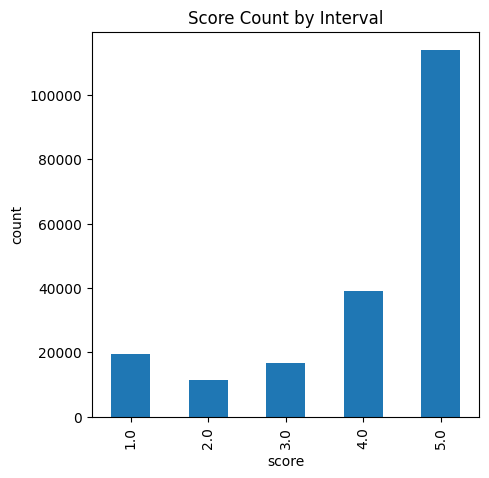

In [75]:
plt.figure(figsize=(5, 5))
data["score"].value_counts().sort_index().plot(kind="bar")
plt.title('Score Count by Interval')
plt.ylabel("count")
plt.show()

## train mean score

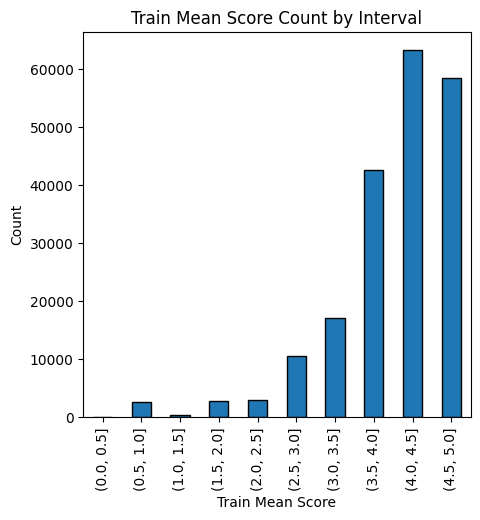

In [73]:
# 按 0.5 为间隔划分 train_mean_score
bins = pd.interval_range(start=0, end=5, freq=0.5)
data_binned = pd.cut(data['train_mean_score'], bins)

# 计算每个区间的计数
count_data = data_binned.value_counts().sort_index()

# 绘制柱状图
plt.figure(figsize=(5, 5))

count_data.plot(kind='bar', edgecolor='black')

# 添加标题和标签
plt.title('Train Mean Score Count by Interval')
plt.xlabel('Train Mean Score')
plt.ylabel('Count')

# 显示图形
plt.show()

## helpfulness

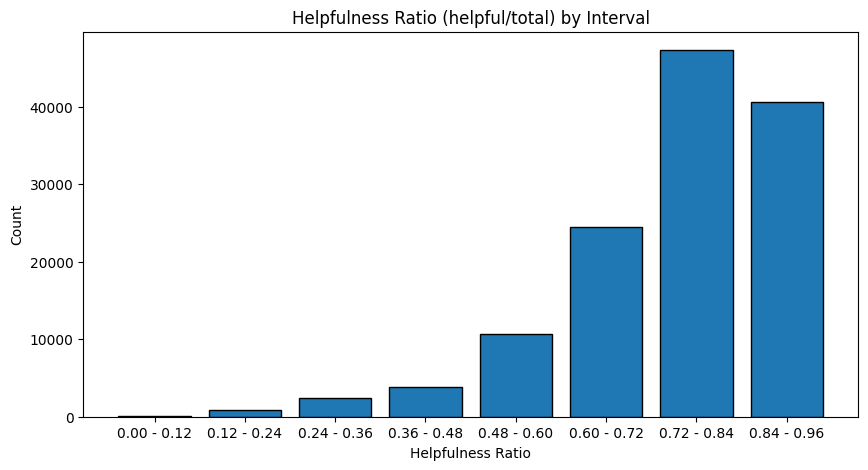

In [72]:
# 按 0.5 为间隔划分 train_mean_score
bins = pd.interval_range(start=0, end=1, freq=0.12)
helpratio_binned = pd.cut(data["helpfulness_helpful"]/data["helpfulness_total"], bins)

# 计算每个区间的计数
count_data = helpratio_binned.value_counts().sort_index()
formatted_labels = [f'{interval.left:.2f} - {interval.right:.2f}' for interval in count_data.index]

# 图片大小
plt.figure(figsize=(10, 5))
# 绘制柱状图
plt.bar(formatted_labels, count_data, edgecolor='black')

# 添加标题和标签
plt.title('Helpfulness Ratio (helpful/total) by Interval')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Count')

# 显示图形
plt.show()

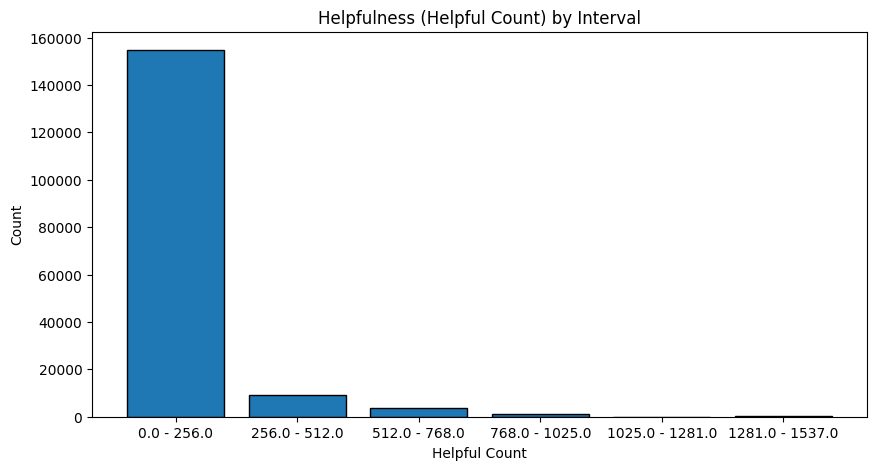

In [76]:
# 按 0.5 为间隔划分 train_mean_score
bins = pd.interval_range(start=data["helpfulness_helpful"].min(), end=data["helpfulness_helpful"].max(), periods=6)
data_binned = pd.cut(data["helpfulness_helpful"], bins)

# 计算每个区间的计数
count_data = data_binned.value_counts().sort_index()
formatted_labels = [f'{round(interval.left, 0)} - {round(interval.right, 0)}' for interval in count_data.index]
# 绘制柱状图
plt.figure(figsize=(10, 5))
plt.bar(formatted_labels, count_data, edgecolor='black')

# 添加标题和标签
plt.title('Helpfulness (Helpful Count) by Interval')
plt.xlabel('Helpful Count')
plt.ylabel('Count')

# 显示图形
plt.show()

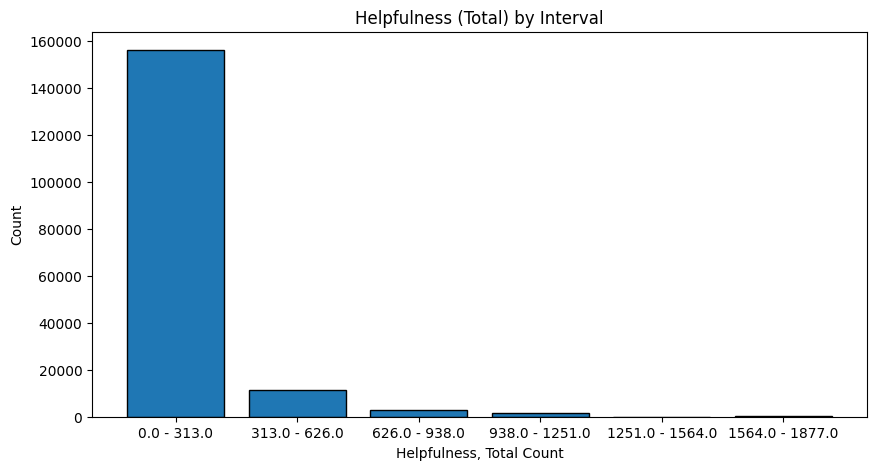

In [79]:
# 按 0.5 为间隔划分 train_mean_score
bins = pd.interval_range(start=data["helpfulness_total"].min(), end=data["helpfulness_total"].max(), periods=6)
data_binned = pd.cut(data["helpfulness_total"], bins)

# 计算每个区间的计数
count_data = data_binned.value_counts().sort_index()
formatted_labels = [f'{round(interval.left, 0)} - {round(interval.right, 0)}' for interval in count_data.index]
# 绘制柱状图
plt.figure(figsize=(10, 5))
plt.bar(formatted_labels, count_data, edgecolor='black')

# 添加标题和标签
plt.title('Helpfulness (Total) by Interval')
plt.xlabel('Helpfulness, Total Count')
plt.ylabel('Count')

# 显示图形
plt.show()

## history

In [112]:
user_history=data.groupby("userId_encode")["index"].count()

In [123]:
user_history.value_counts().sort_index()

index
1      146433
2       12779
3        3368
4        1341
5         553
6         331
7         206
8         108
9          91
10         81
11         51
12         32
13         36
14         27
15         18
16         13
17          5
18         11
20          5
21          3
23          2
24          1
25          3
26          1
27          3
29          1
30          1
31          2
33          2
34          2
38          2
39          3
40          3
41         10
43          1
56          1
66          1
75          1
326         1
Name: count, dtype: int64

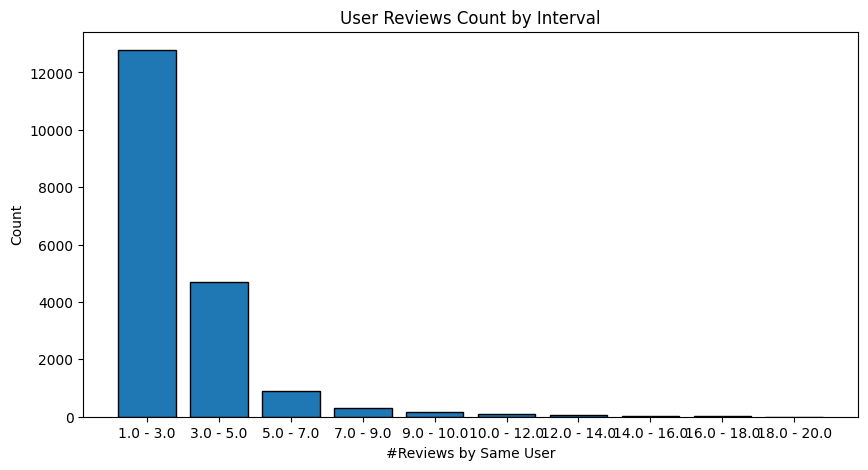

In [128]:
# 由于一个人贡献20条评论的情况较少，故只可视化1-20的部分
bins = pd.interval_range(start=user_history.min(), end=20, periods=10)
data_binned = pd.cut(user_history, bins)

# 计算每个区间的计数
count_data = data_binned.value_counts().sort_index()
formatted_labels = [f'{round(interval.left, 0)} - {round(interval.right, 0)}' for interval in count_data.index]
# 绘制柱状图
plt.figure(figsize=(10, 5))
plt.bar(formatted_labels, count_data, edgecolor='black')

# 添加标题和标签: 用户评论数分布
plt.title('User Reviews Count by Interval')
plt.xlabel('#Reviews by Same User')
plt.ylabel('Count')

# 显示图形
plt.show()

In [5]:
long_summary = pd.read_parquet('long_summary.parquet')

In [11]:
long_summary['long_summary'].str.len().value_counts().sort_index()[:100]

long_summary
1       13
2       40
3       61
4      316
5      291
      ... 
96      38
97      61
98      61
99      62
100     63
Name: count, Length: 100, dtype: int64

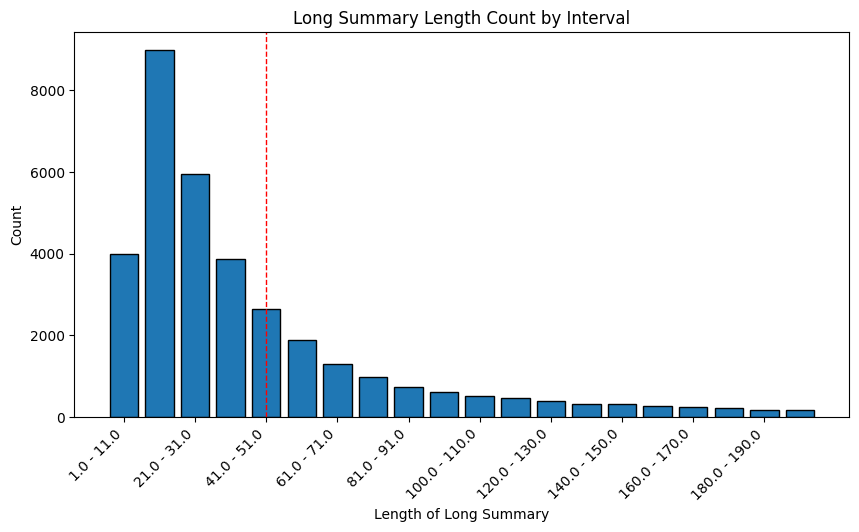

In [21]:
bins = pd.interval_range(start=1, end=200, periods=20)
data_binned = pd.cut(long_summary['long_summary'].str.len(), bins)

# 计算每个区间的计数
count_data = data_binned.value_counts().sort_index()
formatted_labels = [f'{round(interval.left, 0)} - {round(interval.right, 0)}' for interval in count_data.index]
# 绘制柱状图
plt.figure(figsize=(10, 5))
plt.bar(formatted_labels, count_data, edgecolor='black')

# 添加标题和标签: 用户评论数分布
plt.xticks(ticks=range(0, len(formatted_labels), 2), labels=formatted_labels[::2], rotation=45, ha='right')

# 找到包含50的区间索引
for i, interval in enumerate(count_data.index):
    if interval.left <= 50 < interval.right:
        x_index = i
        break
plt.axvline(x=x_index, color='r', linestyle='--', linewidth=1)

plt.title('Long Summary Length Count by Interval')
plt.xlabel('Length of Long Summary')
plt.ylabel('Count')

# 显示图形
plt.show()